# CAPLET AND ZERO COUPON BOND

This project is incentred on the numerical computation of the price of an Interest rate derivative = **Caplet** and of a **zero coupon bond**, following different methodologies.

1 )*Caplet* price has been computed using : finite difference method and its analytical proof, binomial tree, and finite difference method as  replicating portfolio.
The reference models are =  the Hull and White and the Black and Scholes.

**USED THEORY**
Formulas and procedures are from = **"Derivatives : The Theory and Practice of Financial Engineering" PW** ; **Interest Rate Models Brigo Mercurio**, **linked paper for the Crank-Nicholson in the procedure for zcb and interest rate derivatives**

2) The *zero coupon bond* price has been computed using : finite difference method and the analytical closed formula of Hull and White. 

(Results are not always the same due to the use of different parameters in the models implemented; some parameters have cpnstant values in order to  focus better on the study of the numerical procedures)

Furter explanation of the procedures are in the next lines.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.sparse import diags
from scipy.linalg import solve_banded

from scipy.linalg import lu
from scipy import linalg
import scipy.stats as ss
import math

from scipy.linalg import solve_banded

**HULL-WHITE MODEL**

The model is an affine short-rate one (also called Extendend-Vasiceck).
It's importance is mainly due to the fact that it admits **negative rates**.

Here the Term Structure equation with the Zero Coupon boundary condition and the Hull-White r-dynamics (#)


we have to solve the boundary value problem, havig as PDE : 

$$
\frac{{\partial F(T,r)}}{{\partial T}} + \left(\theta(t) - a(t)r(t)\right) \frac{{\partial F(T,r)}}{{\partial r}} + \frac{1}{{2}} \sigma^2 \frac{{\partial^2 F(T,r)}}{{\partial r^2}} - r(t)F(T,r) = 0
$$

with the terminal condition: 
$$
F(r,T,T) = 1
$$

The analytical solution for the short rate is:

$$
r(t) = r(s) e^{-a(t-s)} + \int_s^t e^{-a(t-u)} \theta(u) du + \sigma e^{-a(t-u)} dW(u)
$$

where : 
$$
𝜃(t) = f(0,T) + a f(0,T) + \frac{\sigma^2}{2a}(1 - e^{-aT})
$$

and the Zero coupon bond price is :       

$$
p(t, T) = A(t, T) e^{B(t,T) r(t)}
$$

$$
A(t, T) = \exp\left( B(t,T) f(0,t) - \frac{B(t,T)^2}{1 - e^{-2at}} \right)
$$

$$
B(t, T) =\frac{1}{a} (1 - e^{-a(T-t)})
$$

with f (0, t) being the forward rate and p(0, t) the price of a bond starting today with maturity at time t. 


 - θ is a deterministic function of time, chosen constant for semplicity in this project ( generally calibrated with the market Term Structure)
 - a and σ :  reflect the current and future volatilities of the short-term-interest rate.They can be fitted to the current term structure of interest rates and the current term structure of interest-rate volatility respectively. 
 
  **a** is the mean reverting parameter, and is defined in a way in which the drift of the process will be negative for values of r greater than θ/a and vice-versa.

**CAPLET** 

The caplet is one of the cashflows of a CAP contract.

**CAP CONTRACT** is a  series of call options on interest rates. It guarantees to its holder that otherwhise floating rates will not exceed a specified amount, the variable rate is thus capped.
It is done for example by companies that borrow money with floating rate notes on floating rates, then they cap their positions entering in CAP contract , to ensure that the interest rate determining their loan will not be higher then the cap rate.

on the contrary a **FLOOR CONTRACT** is a series of put options on a floating interest rates, so the cap is below.

The **floating interest rate** is for example the three-months LIBOR. 
We assume in the computation of our caplet that the floating rate is the spot rate rk~r.


**1.1**  **FINITE DIFFERENCE METHOD**

There are three types of finite difference methods to solve PDEs : Explicit that follows backward difference to approximate derivatives, Implicit that uses forward differences and Crank-Nicholson that combine both of them.
I choose to follow **Crank-Nicholson method** for its main advantange of being 𝑂(ℎ2𝑡)  and 𝑂(ℎ2𝑥), with less computational effort to good approximations.


we then need to define a grid with the rates as rows and time as columns.
I decided to apply the *central* and *second central difference* to both variables, we get :      

$$uij =u(ri,tj)$$

$$
\frac{{\partial u(r_i, t_j)}}{{\partial t}} = \frac{{u_{{i,j+1}} - u_{{i,j-1}}}}{{2k}}
$$
$$
\frac{{\partial u(r_i, t_j)}}{{\partial r}} = \frac{{u_{{i+1,j}} - u_{{i-1,j}}}}{{2h}}
$$

$$
\frac{{\partial^2 u(r_i, t_j)}}{{\partial r^2}} = \frac{{u_{{i+1,j}} + u_{{i-1,j}} - 2u_{{i,j}}}}{{h^2}}
$$

then we apply Crank_Nicholson to the term structure PDE of HW
$$
\frac{\partial u_{ij}}{\partial t} = u_{i+1j} - u_{i-1j} = r_i u_{ij} - \left\{ \theta(t) - a(t) \cdot r(t) \right\}\frac{{u_{i+1j}} - u_{i-1j}} {{2h}}- \frac{1}{2}\sigma^2 \frac{u_{i+1j} + u_{i-1j} - 2u_{ij}}{h^2} \cdot "
$$

$$
\frac{\partial u_{ij}}{\partial t} = (\frac{\sigma^2}{2h^2} \left\{ \theta(t) - a(t) \cdot r(t) \right\}) +( \frac{\sigma^2}{h^2 +ri})u_{ij} - (\frac{\sigma^2}{2h}+ \frac{\left\{ \theta(t) - a(t) \cdot r(t) \right\}}{{2h}}) u_{i+1j}
$$
then letting:
$$
alpha = -\frac{\sigma^2}{2h^2} + \frac{\theta(t) - a(t)r(t)}{2h}
$$
$$
beta = \frac{\sigma^2}{h^2} + r_i
$$
$$
gamma=-\frac{\sigma^2}{2h^2} - \frac{\theta(t) - a(t)r(t)}{2h}"
$$
, we can construct two matrices M1, M2 as **tridiag matrices** composed of the previous factors and then letting
$$
\mathbf M_1 \mathbf f_{j-1} = \mathbf M_2 \mathbf f_j,
$$
we can finally solve :
$$
\mathbf f_{j-1} = \mathbf M_1^{-1} \mathbf M_2 \mathbf f_j,
$$


**Terminal**  and **boundary conditions**: 
$$
\begin{aligned}
& f_{i,N} = \max\{i\Delta r - rk, 0\}, \quad i=0,1,\dots, M \\
& f_{0,j} = 0, \quad j=0,1,\dots,N \\
& f_{M,j} = M\Delta rmax - rk e^{-r(N-j)\Delta t}, \quad j=0,1,\dots, N.
\end{aligned}
$$




In [13]:
def caplet_floorlet(r0, rk, r_df, teta, a, tau, sigma, rmin, rmax, M, N, is_caplet=True):
    dr = (rmax - rmin) / float(M)
    dt = tau / float(N)

    gridval = np.zeros((M + 1, N + 1))
    vetr = np.linspace(0, rmax, M + 1)
    i_val = np.arange(0, M + 1)
    j_val = np.arange(0, N + 1)

    if is_caplet:
        gridval[:, -1] = np.maximum(vetr - rk, 0)
        gridval[1, :] = 0
        gridval[-1, :] = rmax - rk * np.exp(-r_df * dt * (N - j_val))
    else:
        gridval[:, -1] = np.maximum(rk - vetr, 0)
        gridval[1, :] = (1 + rk) * np.exp(-r_df * dt * (N - j_val))
        gridval[-1, :] = 0

    eta = (teta - (a * rmin))
    a = -0.5 * (sigma ** 2 * i_val ** 2 / (2 * dr ** 2)) + eta / (2 * dr)
    b = (sigma ** 2 * i_val ** 2 / dr ** 2) + i_val
    c = -0.5 * (sigma ** 2 * i_val ** 2 / (2 * dr ** 2)) - eta / (2 * dr)

    M1 = diags([-a[2:-1], 1 - b[1:-1], -c[1:-2]], [-1, 0, 1]).toarray()
    M2 = diags([a[2:-1], 1 + b[1:-1], c[1:-2]], [-1, 0, 1]).toarray()

    for j in range(N, 0, -1):
        gridval[1:M, j - 1] = np.linalg.inv(M1).dot(M2).dot(gridval[1:M, j])

    return np.interp(r0, vetr, gridval[:, 0])

In [16]:
caplet_price = caplet_floorlet(0.2, 0.135, 0.012, 0.07, 0.045, 5./12., 0.3, 0.1, 0.5, 100,100, is_caplet=True)
floorlet_price = caplet_floorlet(0.2, 0.135, 0.012, 0.07, 0.045, 5./12., 0.3, 0.1, 0.5, 100,100, is_caplet=False)

print("Caplet price:", caplet_price)
print("Floorlet price:", floorlet_price)

Caplet price: 0.06500288317440651
Floorlet price: 5.931845999303176e-15


**graphically..**

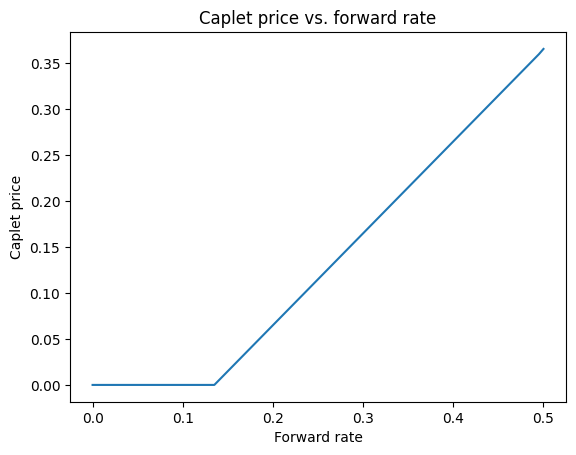

In [17]:

r0 = 0.2
rk = 0.135
r_df = 0.012
teta = 0.07
a = 0.045
tau = 5./12.
sigma = 0.3
rmin = 0.1
rmax = 0.5
M = 100
N = 100

# Call caplet function
caplet_prices = np.zeros(M+1)
vetr = np.linspace(0,rmax,M+1)
for i in range(M+1):
    caplet_prices[i] = caplet_floorlet(vetr[i], rk, r_df, teta, a, tau, sigma, rmin, rmax, M, N, is_caplet=True)

# Plot caplet prices
plt.plot(vetr, caplet_prices)
plt.xlabel('Forward rate')
plt.ylabel('Caplet price')
plt.title('Caplet price vs. forward rate')
plt.show()

**1.2** **ANALYTICAL PROOF:CLOSED BLACK AND SCHOLES FORMULA**

In order to obtain the exact price I develope:

$$
e^{-r_{\text{df}} \cdot \tau} F\Phi\left(d_1(K, F_i, v_i)\right) - K\Phi\left(d_2(K, F_i, v_i)\right)"
$$
$$
d_1 = \frac{{\log\left(\frac{{F_i}}{{K}}\right) + \frac{{v_i^2}}{{2}} \cdot T_{i-1}}}{{\sigma \sqrt{T_{i-1}}}}"
$$
$$
d_2 = d_1 - \sigma \sqrt{T_{i-1}}"
$$

In [ ]:
def d_plus(r0, rk, r_df, sigma, tau):
    num = math.log(r0/rk) + (r_df + 0.5*sigma**2)*(tau)
    den = sigma*math.sqrt(tau)
    return num/den


def d_minus(r0, rk, r_df, sigma, tau):
    return d_plus(r0, rk, r_df, sigma, tau) - sigma*math.sqrt(tau)

def caplet_exact (r0, rk, r_df, teta, a, tau, sigma, rmin, rmax, M, N):
    return (( np.exp(-r_df*(tau))* (r0) * ss.norm.cdf(d_plus(r0, rk, r_df, sigma, tau)) - (rk) * ss.norm.cdf(d_minus(r0, rk, r_df, sigma, tau))))

In [ ]:
caplet_exact (0.2, 0.135, 0.012, 0.07, 0.045, 5./12., 0.3, 0.1, 0.5, 100,100)

0.06426614378712678

**1.3** **BINOMIAL TREE**

$Caplet  = \max\{0, r - rk\}$

using binomial model for interest rate derivatives :

$S = r = { (su ; sd) }$ 
$$u = \sigma \sqrt{dt}$$
the continuously compounded risk-free rate expected in the next time step:
$$
e^{rt} = q u + (1-q)d.
$$

the risk-neutral probability $q$ , which is
$$
q = \frac{e^{rt} - d}{u-d}.
$$

In [9]:
def binomial_tree_caplet(S, K, r, T, sigma, n):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))                       
    d = 1 / u

    q = (np.exp(r * dt) - d) / (u - d)

    # Initialize underlying and option values at maturity
    irunderlying = np.zeros((n + 1, n + 1))
    option_values = np.zeros((n + 1, n + 1))

    for i in range(n + 1):
        irunderlying[i, n] = S * u ** (n - i) * d ** i
        option_values[i, n] = max(irunderlying[i, n] - K, 0)

    # expected stock price and option value for each node
    for j in range(n - 1, -1, -1):
        for i in range(j + 1):
            irunderlying[i, j] = irunderlying[i, j + 1] * d
            option_values[i, j] = (q * option_values[i, j + 1] +
                                   (1 - q) * option_values[i + 1, j + 1]) * np.exp(-r * dt)

    caplet_price = option_values[0, 0] * np.exp(-r * dt)
    return caplet_price


S = 0.2  # Initial interest rate
K = 0.134  # Strike price
r = 0.012  # Risk-free discounting_interest rate
T = 5. / 12  # Time to maturity
sigma = 0.3  # Volatility
n = 100      # Number of time steps


caplet_price = binomial_tree_caplet(S, K, r, T, sigma, n)
print("Caplet price:", caplet_price)


Caplet price: 0.06686982818268644


**CAPLET AS REPLICA PORTFOLIO**

looking at the cashflow of the Caplet, we can observe that is the same as $$\frac{1}{{1 + r}} \max(r - rK, 0)$$ received at t(i-1) = *definition of the LIBOR rate.*

The cashflow can be rewritten as $$ \max\left(1-\frac{{1 + rk}}{{1 + r}}, 0\right)$$, 
but
$$\frac{{1 + rk}}{{1 + r}}  \text{  price of bond at } t_i$$

$$ \text{paying} \ { (1+rk) }  \text{ at }  t_i$$ ; we can conclude that the *Caplet* is equivalent to a *Put Option* expiring at ti-1 on a bond at ti.

-(There are different notations to express this replica, I use: Derivatives PW one)



the price is here estimated with Crank-Nicholson as before to approximate the derivatives, then I use the linalg.lu  function from scipy  to perform the LU decomposition of matrix A, resulting in the matrices P, L, and U. 
The lU decomposition is  a factorization of a square matrix into a lower triangular matrix (L) and an upper triangular matrix (U), with the permutation matrix P representing the row interchanges.

In [ ]:
def put_bond(r0, rk, r_df, teta, a, tau, sigma, rmin, rmax, M, N):
    dr = (rmax - rmin) / float(M)
    dt = tau / float(N)

    gridval = np.zeros((M+1,N+1))
    vetr = np.linspace(0,rmax,M+1)
    i_val = np.arange(0,M+1)
    j_val = np.arange(0,N+1)


    gridval[:,-1] = np.maximum((1 - ((1+rk)/(1+vetr))),0)
    
    gridval[1,:] = (1+ rk)*np.exp(-r_df*dt*(N-j_val))
    gridval[-1,:] = 0

    eta = (teta - (a*rmin))

    a = .5 * (eta * dt * i_val - sigma**2 * dt * i_val**2)
    b = 1 + sigma**2 * dt * i_val**2 + rmin * dt
    c = -.5 * (eta * dt * i_val + sigma**2 * dt * i_val**2)

    A = np.diag(a[2:M], -1) + np.diag(b[1:M]) + np.diag(c[1:M-1], 1)

    P, L, U = linalg.lu(A)
    mat = np.zeros(M-1)
    for j in reversed(range(N)):
        mat[0] = np.dot(-a[1], gridval[0, j])
        x = linalg.solve(L,gridval[1:M, j+1]+mat)
        y = linalg.solve(U, x)
        gridval[1:M, j] = y

    return np.interp(r0, vetr, gridval[:,0])

In [ ]:
put_bond(0.2, 0.135, 0.012, 0.07, 0.045, 5./12., 0.3, 0.1, 0.5, 100,100)

0.05528129450689287

**closed formula ZCP (zerocoupon-put) , under HW**

In [12]:
def zcp(t, T, S, X, r, sigma, a):
    PTtT = math.exp(-r * (T - t))
    PTtS = math.exp(-r * (S - t))
    B_TS = 1/a * ( 1 - math.exp(-a*(S-T)))

    sigmap = sigma * math.sqrt((1 - math.exp(-2 * a * (T - t))) / (2 * a))*B_TS
    h = (1 / sigmap) * math.log(PTtS / PTtT * X) + sigmap / 2

    put_price = X * PTtT * ss.norm.cdf(-h + sigmap) - PTtS * ss.norm.cdf(-h)
    return put_price


t = 0.0  # Current time
T = 5 / 12 # Maturity time of the bond
S = 1  # Time to exercise the put option
X = 1  # Strike price
r = 0.065  # Risk-free interest rate
sigma = 0.3  # Volatility
a = 0.045  # Hull-White parameter


put_price = zcp(t, T, S, X, r, sigma, a)
print("Put option price:", put_price)

Put option price: 0.06262663960012749


**2** **ZERO COUPON BOND**

 **2.1** **CLOSED FORMULA FOR ZERO COUPON-BOND**

here is is the analytical price of a zero coupon bond following Hull and White model showed at the starting point of this project (#)

In [7]:
def HW(r0, kappa, theta, sigma, T, N):
    dt = T / N
    t_values = np.linspace(0, T, N+1)

    #1) Simulation of short-term interest rate paths using the Hull-White model
    dW = np.random.normal(size=N) * np.sqrt(dt)
    r = np.zeros(N+1)
    r[0] = r0

    for i in range(1, N+1):
        drift = (theta - kappa * r[i-1]) * dt
        diffusion = sigma * np.sqrt(dt) * dW[i-1]
        r[i] = r[i-1] + drift + diffusion
   
    return range(n+1), r


In [ ]:
x, y = HW(0.02, 0.135, 0.07,0.3,5./12,100)

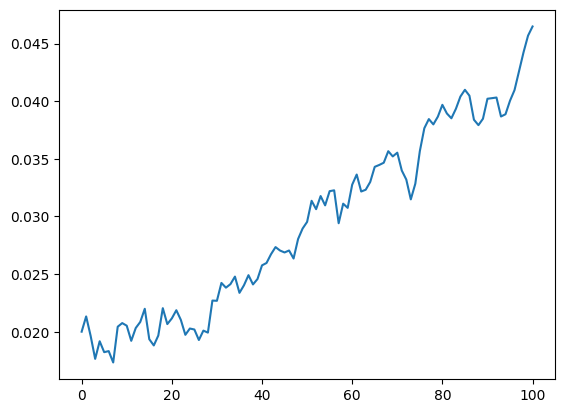

In [ ]:
plt.plot(x,y)

In [ ]:
def price_zero_coupon_bond(r, sigma, a, t, T):
    B = (1 - math.exp(-a * (T - t))) / a
    term = (sigma**2 / (4 * a)) * (1 - math.exp(-2 * a * t)) * (B**2)
    A = math.exp(B * r - term)
    return A * math.exp(-B * r)

r = 0.02  # Short-term interest rate
sigma = 0.03  # Volatility
a = 0.045  # Mean reversion speed
t = 0.5  # Current time
T = 1.0  # Maturity time

bond_price = price_zero_coupon_bond(r, sigma, a, t, T)
print("Zero Coupon Bond Price:", bond_price)

Zero Coupon Bond Price: 0.9999462197816296


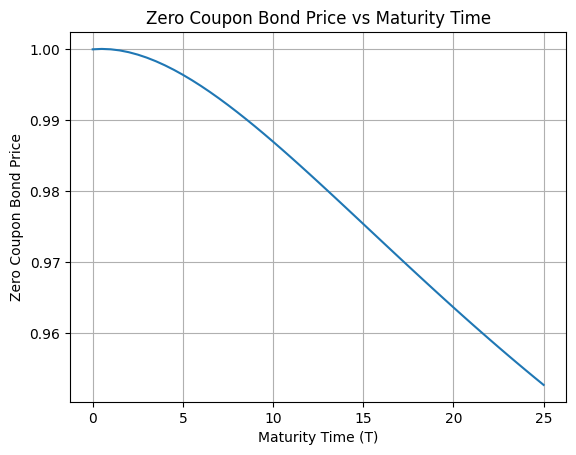

In [ ]:
T_values = np.arange(0.0, 25.5, 0.5)
bond_prices = [price_zero_coupon_bond(r, sigma, a, t, T) for T in T_values]

plt.plot(T_values, bond_prices)
plt.xlabel('Maturity Time (T)')
plt.ylabel('Zero Coupon Bond Price')
plt.title('Zero Coupon Bond Price vs Maturity Time')
plt.grid(True)
plt.show()

**2.2** **FINITE DIFFERENCE METHOD FOR ZERO COUPON BOND**

the procedure for solving numerically is similar to those of the Caplet.
The PDE is the HW one, solve with CN method. 

Now  *terminal condition*: 
$$u(r, T) = 1$$

Boundary conditions: 
$$\frac{{\partial u(rmin, t)}}{{\partial r}} = 0 
$$

$$\frac{{\partial u(rmax,t)}}{{\partial r}} = 0 
$$


**((((**the reference methodology was the one of the linked paper, I just tried to implement a different method using solve.banded****))))****

In [5]:

def price_zero_coupon_bond(r0, rmin, rmax, dr, T):
    M = int((rmax - rmin) / dr)
    dt = T
    N = int(T / dt)

    gridval = np.zeros((M + 1, N + 1))
    vetr = np.linspace(rmin, rmax, M + 1)
    i_val = np.arange(0, M + 1)
    j_val = np.arange(0, N + 1)
    
    #terminal condition
    gridval[:, -1] = 1  # Final condition

    sigma = 0.3  
    
    a = 0.5 * dt * (sigma**2 * vetr - r0) * vetr
    b = 1 - dt * (sigma**2 * vetr**2 + r0)
    c = 0.5 * dt * (sigma**2 * vetr + r0) * vetr
    
    #boundary conditions
    A = np.zeros((3, M + 1))
    A[0, 1:] = -a[1:]
    A[1, :] = b
    A[2, :-1] = -c[:-1]

    for j in reversed(range(N)):
        gridval[:, j] = solve_banded((1, 1), A, gridval[:, j + 1])

    return np.interp(r0, vetr, gridval[:, 0])

# Example usage:
rmin = 0.1
rmax = 0.5
dr = 0.004
T = 5./12
r0 = 0.02

bond_price = price_zero_coupon_bond(r0, rmin, rmax, dr, T)
print("Zero Coupon Bond Price:", bond_price)

Zero Coupon Bond Price: 1.0085501376532662


The method here chosen is **solve_banded**, which solve a system of linear equations using banded matrix representation. 
Here a brief explanation :
 - for j in reversed(range(N)): iterates over the indices of the columns in the grid in reverse order, starting from N-1 and going down to 0. The variable j represents the current column index.

- solve_banded((1, 1), A, gridval[:, j + 1]): The function solve_banded is used to solve a banded linear system of equations. It takes three arguments: the band widths, the banded matrix A, and the right-hand side vector gridval[:, j + 1];     
- A represents the banded matrix of the linear system ; (1, 1) indicates that the matrix A has one sub-diagonal and one super-diagonal.     
- gridval[:, j + 1] is the right-hand side vector for the current column j + 1.
- gridval[:, j] = solve_banded((1, 1), A, gridval[:, j + 1]): The result of the solve_banded function is assigned to the column j of the gridval matrix. This updates the values in the jth column of gridval with the solution obtained from solving the linear system.

By iterating over the columns in reverse order and solving the linear system using the banded matrix representation, this code efficiently calculates the price for each column of the grid based on the values in the next column.
